In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np

In [3]:
import tensorflow as tf
import tensorflow_hub as hub

In [4]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Lambda, Activation, Conv1D, \
                                    MaxPooling1D, Flatten, Reshape, Bidirectional, \
                                    BatchNormalization, Dropout, add, LSTM, \
                                    TimeDistributed
from tensorflow.keras.optimizers import RMSprop, Adam, Adamax, SGD
from tensorflow.keras.regularizers import l2

In [5]:
from src.keras_bert import convert_single_example, \
                           create_tokenizer_from_hub_module, \
                           InputExample, \
                           initialize_vars, \
                           BertLayer

In [6]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score as scikit_f1_score

In [7]:
# Initialize session
sess = tf.compat.v1.Session()

In [8]:
with tf.device("gpu:0"):
    print("GPU enabled")

GPU enabled


#### Custom Functions

In [9]:
from src.callbacks import PlotCurvesTF as PlotCurves
from src.eval_metrics_seq import f1_macro, f1_micro 
from src.load_data import load_data

Using TensorFlow backend.


### Load Data

In [10]:
train_data, valid_data, test_data, metadata = load_data()

### Load BERT

In [11]:
BERT_PATH = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

In [12]:
bert = hub.Module(BERT_PATH, trainable=False)

### Prepare data

In [13]:
n_tags = 2
batch_size = 2
max_len = 60
max_seq_length = 512
if max_seq_length > 512:
    print('!!!!!!! WARNING: BERT does not accept length > 512')
    max_seq_length = 512

In [14]:
def get_padding_sentence(max_seq_length, padding_text='ENDPAD'):
    
    tokenizer = create_tokenizer_from_hub_module(BERT_PATH)

    example_sent = InputExample(guid=None, text_a=" ".join(padding_text), text_b=None, label=0)

    (input_ids, input_mask, segment_ids, label) = \
            convert_single_example(tokenizer, example_sent, max_seq_length=max_seq_length)
    
    return {"input_ids":input_ids, "input_mask":input_mask, "segment_ids":segment_ids}

In [15]:
def get_input(data_, max_len, max_seq_length, padding_sent, limit=None):
    
    # limit data if not an even number when batch_size=2
    if not limit:
        limit = len(data_) if len(data_)%2 == 0 else len(data_)-1

    data_ = data_[:limit]
    
    tokenizer = create_tokenizer_from_hub_module(BERT_PATH)

    X = []
    y = []
    for article in data_:
        input_ids_seq = []
        input_mask_seq = []
        segment_ids_seq = []
        y_seq = []
        for i in range(max_len):
            if i < len(article['sentences']):
                X_sent = " ".join(article['sentences'][i]['sentence']
                                  .replace('\n', ' ').strip().split()[0:max_seq_length])
                
                y_sent = article['sentences'][i]['label']
                
                example_sent = InputExample(guid=None, text_a=" ".join(X_sent), text_b=None, label=y_sent)

                (input_ids, input_mask, segment_ids, label) = \
                        convert_single_example(tokenizer, example_sent, max_seq_length=max_seq_length)

            else:    
                input_ids = padding_sent['input_ids']
                input_mask = padding_sent['input_mask']
                segment_ids = padding_sent['segment_ids']
                label = 0

            input_ids_seq.append(input_ids)
            input_mask_seq.append(input_mask)
            segment_ids_seq.append(segment_ids)
            y_seq.append([label])
        
        X_seq = (np.array(input_ids_seq),
                 np.array(input_mask_seq),
                 np.array(segment_ids_seq))

        X.append(X_seq)
        y.append(y_seq)
            
    return np.array(X), np.array(y)

In [ ]:
padding_sent = get_padding_sentence(max_seq_length, padding_text='ENDPAD')

In [17]:
X_tra, y_tra = get_input(train_data, max_len, max_seq_length, padding_sent, limit=None)
X_val, y_val = get_input(valid_data, max_len, max_seq_length, padding_sent, limit=None)

In [18]:
X_tra.shape, X_val.shape#, X_test.shape

((250, 3, 60, 512), (32, 3, 60, 512))

In [19]:
y_tra.shape, y_val.shape#, y_test.shape

((250, 60, 1), (32, 60, 1))

In [20]:
padding_sent['input_ids'] == list(X_tra[0][0][-1])

True

## Build Model

In [33]:
def BERTEmbeddingStack(x):
    embeds = []
    for art in tf.unstack(tf.reshape(x, (batch_size, 3, 60, 512))):
        art = tf.cast(art, dtype="int32")
        bert_inputs = dict(
            input_ids=art[0], 
            input_mask=art[1], 
            segment_ids=art[2]
        )
        embeds.append(bert(bert_inputs, signature="tokens", as_dict=True)["pooled_output"])
    print(tf.stack(embeds, 0))
    return tf.stack(embeds, 0)

In [34]:
def build_model_2(max_len):
    
    input_text = Input(shape=(3, max_len, max_seq_length))
    
    bert_output = Lambda(BERTEmbeddingStack, output_shape=(None, None, max_len, 768))(input_text)
    
    x = Bidirectional(LSTM(units=256, return_sequences=True))(bert_output)
    x = Dropout(0.2)(x)
                      
    pred = TimeDistributed(Dense(1, activation="sigmoid"))(x)

    return Model(inputs=[input_text], outputs=pred)

In [35]:
learningrate = 2e-5
optimizer = Adam(lr=learningrate)
optimizer_str = 'adam'
loss = 'binary_crossentropy'
metrics = ['acc', f1_macro, f1_micro]

In [36]:
model = build_model_2(max_len)
model.summary()

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

W1013 01:13:20.298929 140259289120896 deprecation.py:506] From /home/aorus/workspaces/simge/Master_Thesis/.env/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1013 01:13:20.301933 140259289120896 deprecation.py:506] From /home/aorus/workspaces/simge/Master_Thesis/.env/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1013 01:13:20.302424 140259289120896 deprecation.py:506] From /home/aorus/workspaces/simge/Master_Thesis/.env/lib/python3.6/site-packag

Tensor("lambda/stack:0", shape=(2, 60, 768), dtype=float32)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3, 60, 512)]      0         
_________________________________________________________________
lambda (Lambda)              (2, 60, 768)              0         
_________________________________________________________________
bidirectional (Bidirectional (2, 60, 512)              2099200   
_________________________________________________________________
dropout (Dropout)            (2, 60, 512)              0         
_________________________________________________________________
time_distributed (TimeDistri (2, 60, 1)                513       
Total params: 2,099,713
Trainable params: 2,099,713
Non-trainable params: 0
_________________________________________________________________


In [37]:
model_name = 'RQ2_test_bert_model_2' + \
             '_maxlen_' + str(max_len) + \
             '_' + optimizer_str + \
             '_lr_' + str(learningrate) + \
             '_lrreduction' + \
             '_loss_' + loss

model_dir = './Model/' + model_name.split('model')[0] + 'model/' + model_name
results_file = os.path.join(model_dir, 'model_results_file.txt')

### Train Model

In [38]:
# Instantiate variables
initialize_vars(sess)

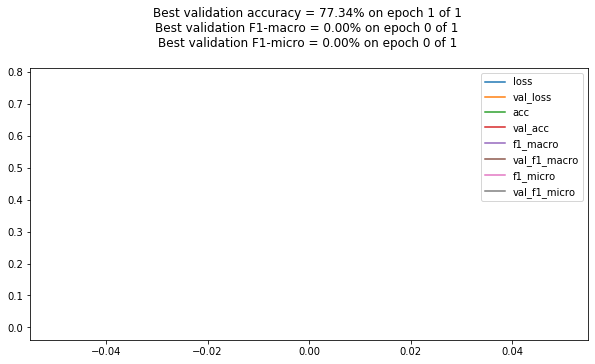

250/250 [==============================] - 398s 2s/sample - loss: 0.6434 - acc: 0.6717 - f1_macro: 0.0432 - f1_micro: 0.0106 - val_loss: 0.5695 - val_acc: 0.7734 - val_f1_macro: 0.0000e+00 - val_f1_micro: 0.0000e+00


In [60]:
model.fit(X_tra, y_tra, 
          epochs=1,
          batch_size=batch_size, 
          validation_data=(X_val, y_val),
          callbacks=[
            PlotCurves(model_name=model_name, model_dir=model_dir, jnote=False, plt_show=False)
          ])

### Load the best Model

In [34]:
model_name

'RQ2_elmo_model_10_maxlen_60_adam_lr_0.0001_lrreduction_loss_binary_crossentropy'

In [64]:
best_model = model

### Evaluation

In [65]:
def get_scores(model, data_, batch_size, max_len, max_seq_length, padding_sent,
               results_file=None, print_out=False):
    
    def unpad(X, y_preds):
        y_unpad = []
        for ai, art in enumerate(X):
            for si, sen_inp_ids in enumerate(art[0]):
                if list(sen_inp_ids) != list(padding_sent['input_ids']):
                    y_unpad.append(y_preds[ai][si])
        return y_unpad
    
    X, y_true = get_input(data_, max_len, max_seq_length, padding_sent, limit=None)
    y_true = unpad(X, y_true)
    y_true = [y[0] for y in y_true]
    
    y_preds = model.predict(X, batch_size=batch_size)
    y_preds = unpad(X, y_preds)
    y_preds = [round(y[0]) for y in y_preds]
    
    clsrpt = classification_report(y_true, y_preds)
    sfm = scikit_f1_score(y_true, y_preds, average='macro')
    
    if print_out:
        print(clsrpt)
        print('\nScikit_F1_Macro:', sfm)

    if results_file:
        with open(results_file, 'a') as f:
            f.write('\n' + clsrpt + '\n' + str(sfm) + '\n\n')
            
    return sfm

#### Validation Set

In [66]:
with open(results_file, 'w') as f:
    f.write('\n---------------- Validation ----------------\n')
val_f1 = get_scores(best_model, valid_data, batch_size, max_len, max_seq_length, padding_sent, 
                    results_file, print_out=True)

              precision    recall  f1-score   support

           0       0.67      1.00      0.81       269
           1       0.00      0.00      0.00       130

   micro avg       0.67      0.67      0.67       399
   macro avg       0.34      0.50      0.40       399
weighted avg       0.45      0.67      0.54       399


Scikit_F1_Macro: 0.4026946107784431


/home/aorus/workspaces/simge/Master_Thesis/.env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/aorus/workspaces/simge/Master_Thesis/.env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Test Set

In [67]:
with open(results_file, 'a') as f:
    f.write('\n---------------- Test ----------------\n')
test_f1 = get_scores(best_model, test_data, batch_size, max_len, max_seq_length, padding_sent,
                     results_file, print_out=True)

              precision    recall  f1-score   support

           0       0.74      1.00      0.85       325
           1       0.00      0.00      0.00       116

   micro avg       0.74      0.74      0.74       441
   macro avg       0.37      0.50      0.42       441
weighted avg       0.54      0.74      0.63       441


Scikit_F1_Macro: 0.42428198433420367
